# Image Denoising

In this notebook you will see an example of an **image denoising**, using an _autoencoder_, inspired into Francois Chollet [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

## What is an image denoising?

An **image denoising** is an algorithm that learns _what_ is noise (in some _noisy image_) and _how_ to remove it, based into the _true signal_ / _original_ (image without noisy). The results are images very close to the true ones, for example, as in the image below:

![Example of image denoising](https://upload.wikimedia.org/wikipedia/en/e/e8/ROF_Denoising_Example.png)

## Image denoising using autoencoders

**Autoencoders** are based on _Neural Networks (NNs)_ and are known as **Convolutional Neural Networks** (**CNNs** or **convnets**). A **convnet** is a __Deep Learning algorithm__ which takes an input image, assign importance (learnable weight, biases and retains spatial relationships in the data into each one of theirs layers) to various aspects/parts in the image and is able to differentiate/reconstruct the same.

The general idea behind this kind of code can be visualized here:

![General autoencoder](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png)

Then, the **autoencoder** compreehends an _encoder_ and a _decoder_. The **encoder** does the _encoding process_, i.e., transforms the image into a _compressed representation_ at the same time that starts the noisy reduction. Then, the _compressed representation_ goes to **decoder** that performs the _decoder process_, restoring the image to its true and recognizable shape. At the end of the process, we remove almost all noise in the image.

## Libraries

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

## Data

Here, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

This is a dataset of 60 000 images of size 28 $\times$ 28 grayscale images of hand written of 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), along with a test set of 10 000 images.

### Importing data

This dataset is mostly used in _classification problems_, that is why they have the images and a second information, the labels of each image.

But, as we are going to map digits images to clean them, we are not going to use the labels.

In this way, our process is going to take the **noised images** and clear the same based into the **true images** as _targets_.

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

### Pre-processing data

Because here we are doing a simple example, we will use a fraction of the complete dataset: just 1000 images, dividing if on 700 as _train_ and 300 images as _test_.

In [5]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

We are going to normalize the images between 0 and 1 and to reshape them.

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

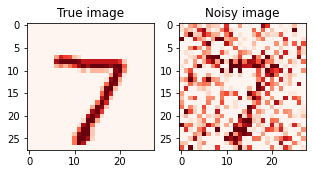

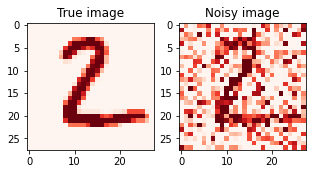

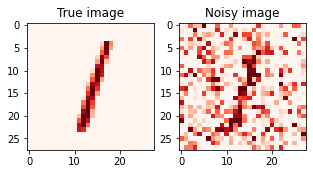

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## Building the Autoencoder

Defining the input images for the **autoencoder**.

In [9]:
input_img = keras.Input(shape = (dimension, dimension, 1))

### Encoder

In [10]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

### Decoder

In [11]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
x = layers.UpSampling2D(size = (2, 2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D(size = (2, 2))(x)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)

### Autoencoder

In [12]:
autoencoder = keras.Model(input_img, decoded)

Visualizing the autoencoder.

In [13]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)       

### Compilation

In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Fitting

In [15]:
validation_split = 0.8
history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40
7/7 [==============================] - 1s 72ms/step - loss: 0.5926 - val_loss: 0.4993
Epoch 2/40
7/7 [==============================] - 0s 57ms/step - loss: 0.4989 - val_loss: 0.4638
Epoch 3/40
7/7 [==============================] - 0s 54ms/step - loss: 0.4516 - val_loss: 0.4265
Epoch 4/40
7/7 [==============================] - 0s 53ms/step - loss: 0.4046 - val_loss: 0.3686
Epoch 5/40
7/7 [==============================] - 0s 53ms/step - loss: 0.3384 - val_loss: 0.2967
Epoch 6/40
7/7 [==============================] - 0s 53ms/step - loss: 0.2699 - val_loss: 0.2410
Epoch 7/40
7/7 [==============================] - 0s 53ms/step - loss: 0.2273 - val_loss: 0.2148
Epoch 8/40
7/7 [==============================] - 0s 53ms/step - loss: 0.2075 - val_loss: 0.2056
Epoch 9/40
7/7 [==============================] - 0s 55ms/step - loss: 0.1972 - val_loss: 0.1954
Epoch 10/40
7/7 [==============================] - 0s 57ms/step - loss: 0.1873 - val_loss: 0.1881
Epoch 11/40
7/7 [============

### Tracking the history of the training stage

In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [17]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training.

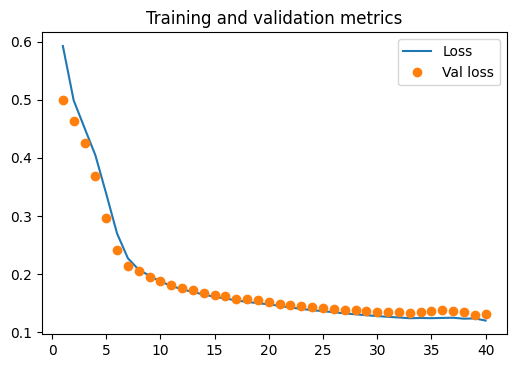

In [18]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

### Prediction

In [19]:
all_denoised_images = autoencoder.predict(x_test_noisy)

### Evaluation

In [20]:
test_loss  = autoencoder.evaluate(x_test_noisy, x_test, batch_size = 20)
test_loss

15/15 [==============================] - 0s 8ms/step - loss: 0.1299


0.12987352907657623

# Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

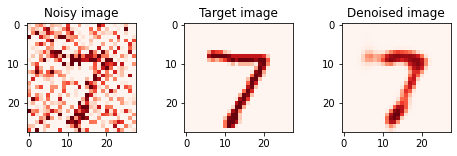

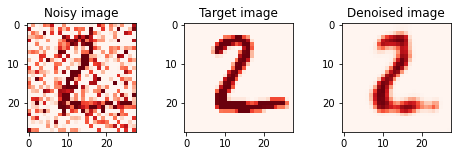

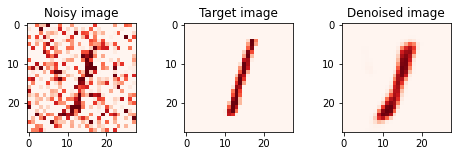

In [21]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')
    plt.savefig(f'comparison-{i}.png')